# Demo - Time Series Forecasting with TabPFN  🎉

Welcome to the demo of TabPFN for time series forecasting!

In this demo, we will show you how to use TabPFN for time series forecasting. Concretely, we will:

1. **Load time series data** -- you can also bring in time series data from your own problem
2. **Add features** -- we will use default features, but feel free to experiment with your own features!
3. **Perform prediction** -- zero-shot! 😉
4. **Visualize the forecasting results**


## Setup

## Load Time Series Data

In this demo, we will use the time series dataset from [Chronos Dataset](https://huggingface.co/datasets/autogluon/chronos_datasets) on HuggingFace. Also, we'll keep it short and work with just 2 time series from the dataset.

Feel free to explore other datasets by using the dataset names from Chronos Dataset on HuggingFace or even use time series data of your own problem.

In [1]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 16
# num_time_series_subset = 150

In [2]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from tabpfn_time_series.data_preparation import to_gluonts_univariate, generate_test_X

prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

Let's take a look at the time series data.

In [3]:
# from tabpfn_time_series.plot import plot_actual_ts

# plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

## Adding Features

In our paper, we propose adding `running_index` and `calendar_features` to the table.

**Feel free to experiment with your own features!**

To do that, simply define your own feature functions and pass them to the `FeatureTransformer`.

In [8]:
from tabpfn_time_series import FeatureTransformer #, DefaultFeatures

from tabpfn_time_series.features import (
    RunningIndexFeature,
    CalendarFeature,
    AutoSeasonalFeature,
)

selected_features = [
    RunningIndexFeature(),
    CalendarFeature(),
    AutoSeasonalFeature(),
    # DefaultFeatures.add_running_index,
    # DefaultFeatures.add_calendar_features,
]

feature_transformer = FeatureTransformer(selected_features)

train_tsdf, test_tsdf = feature_transformer.transform(train_tsdf, test_tsdf)


Let's take a look at the tables (train and test) before we proceed to do predictions.

✅ Realize that we have added some features into the tables.

## Prediction

Now, let's perform prediction.

We provide two options, `TabPFNMode.LOCAL` and `TabPFNMode.CLIENT`, as the backend for TabPFN.

- `TabPFNMode.LOCAL` uses your local machine to run TabPFN.
- `TabPFNMode.CLIENT` uses TabPFN's inference service provided by [tabpfn-client](https://github.com/automl/tabpfn-client)

For this demo, we'll use `TabPFNMode.CLIENT` to perform prediction. If you have not use the client before, you'll be prompted to create an account.

Note: if your machine doesn't have a GPU, using `TabPFNMode.CLIENT` is recommended -- must faster 😉.


In [9]:
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)

pred = predictor.predict(train_tsdf, test_tsdf)

GPU 0::   0%|          | 0/2 [00:00<?, ?it/s]/home/turbo/mambaforge-pypy3/envs/time_series/lib/python3.10/site-packages/tabpfn/base.py:101: UserWarning: Downloading model to tabpfn-v2-regressor-2noar4o2.ckpt.
  model, bardist, config_ = load_model_criterion_config(
GPU 1::   0%|          | 0/2 [00:00<?, ?it/s]/home/turbo/mambaforge-pypy3/envs/time_series/lib/python3.10/site-packages/tabpfn/base.py:101: UserWarning: Downloading model to tabpfn-v2-regressor-2noar4o2.ckpt.
  model, bardist, config_ = load_model_criterion_config(
GPU 1::   0%|          | 0/2 [00:00<?, ?it/s]/home/turbo/mambaforge-pypy3/envs/time_series/lib/python3.10/site-packages/tabpfn/base.py:101: UserWarning: Downloading model to tabpfn-v2-regressor-2noar4o2.ckpt.
  model, bardist, config_ = load_model_criterion_config(
/home/turbo/mambaforge-pypy3/envs/time_series/lib/python3.10/site-packages/tabpfn/base.py:101: UserWarning: Downloading model to tabpfn-v2-regressor-2noar4o2.ckpt.
  model, bardist, config_ = load_model

In [35]:
from tabpfn_time_series.experimental.noisy_transform import TabPFNNoisyTranformPredictor

noise_level_candidates = [0, 1, 2]
# noise_level_candidates = [0.25, 0.5, 1, 2, 10]
all_noisy_preds = {}

for noise_level in noise_level_candidates:
    noisy_predictor = TabPFNNoisyTranformPredictor(
        tabpfn_mode=TabPFNMode.CLIENT,
        noise_level=noise_level,
    )

    noisy_pred = noisy_predictor.predict(train_tsdf, test_tsdf)
    all_noisy_preds[noise_level] = noisy_pred

Predicting time series: 100%|██████████| 16/16 [00:00<00:00, 2758.62it/s]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Processing: 100%|██████████| [00:02<00:00]
Predicting time series: 100%|██████████| 16/16 [00:00<00:00, 2880.33it/s]
Processing: 100%|██████████| [00:01<00:00]
Processing: 100%|██████████| [00:00<00:00]
Processing: 100%|██████████| [00:00<00:00]
Processing: 100%|██████████| [00:00

## Visualize the Results

Let's visualize the forecasting results.

Also, note that we provide both **point prediction** and **quantile prediction**, how amazing! 😄

In [10]:
train_tsdf.item_ids

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', name='item_id')

In [11]:
import random
item_ids_to_plot = random.sample(list(train_tsdf.item_ids), 10)
item_ids_to_plot

[7, 1, 8, 6, 14, 5, 3, 4, 10, 15]

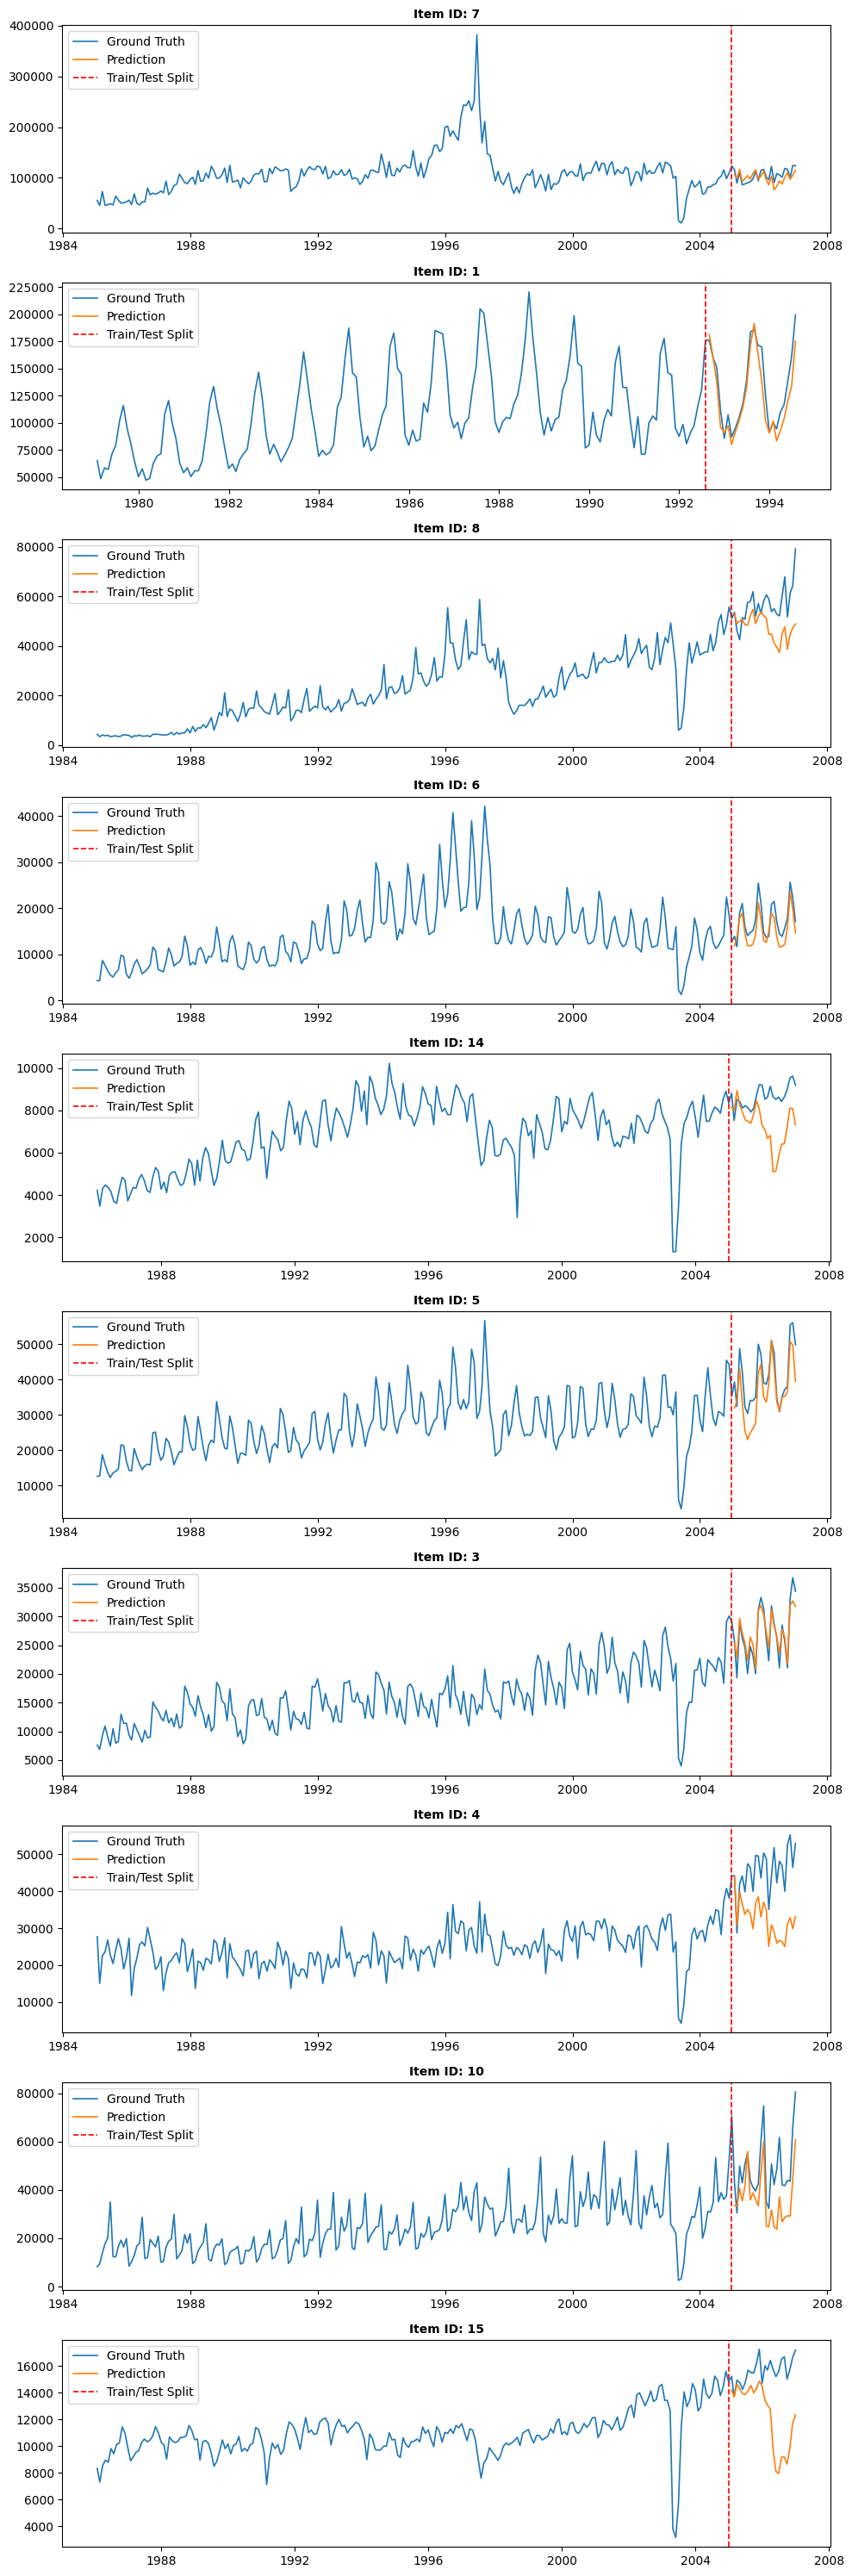

In [12]:
from tabpfn_time_series.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
    item_ids=item_ids_to_plot,
    show_quantiles=False,
)


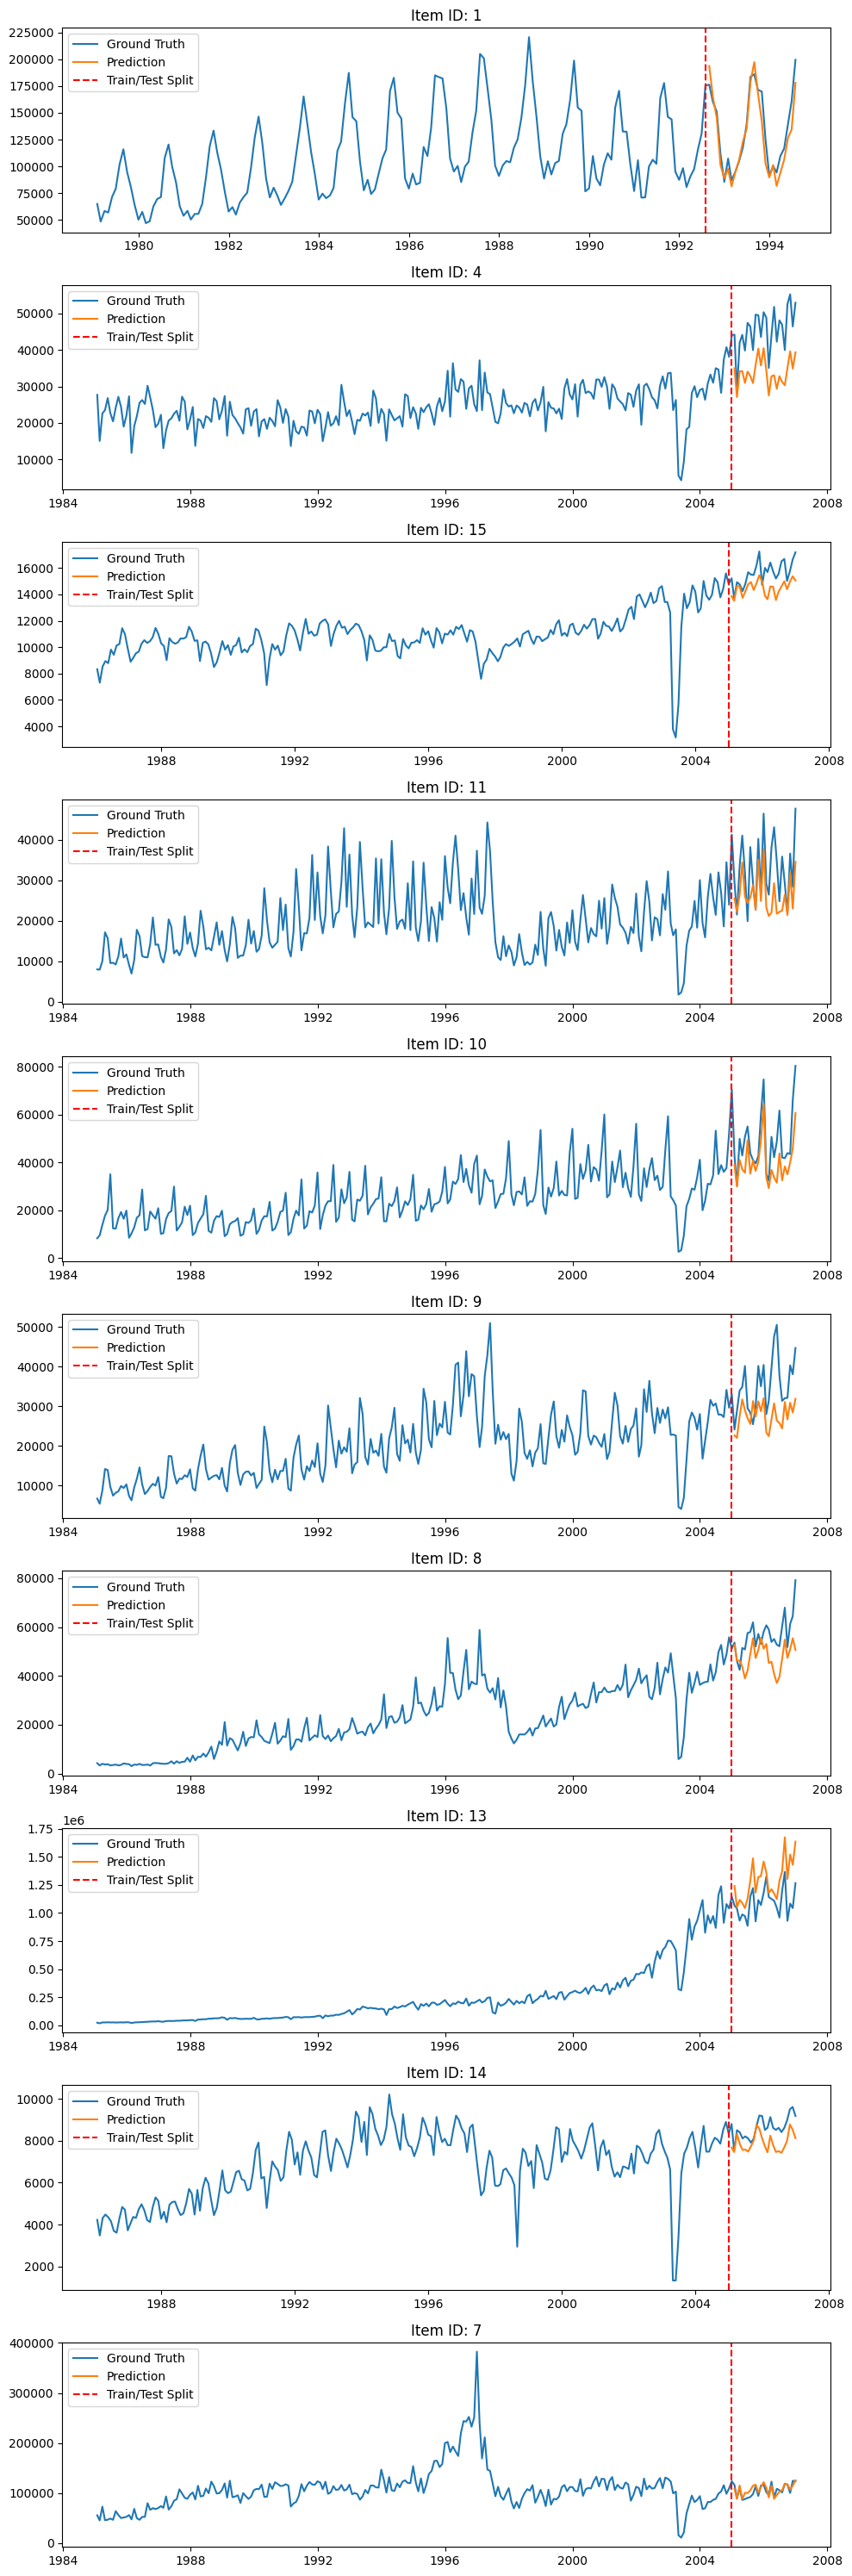

In [42]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=all_noisy_preds[1],
    item_ids=item_ids_to_plot,
    show_quantiles=False,
)

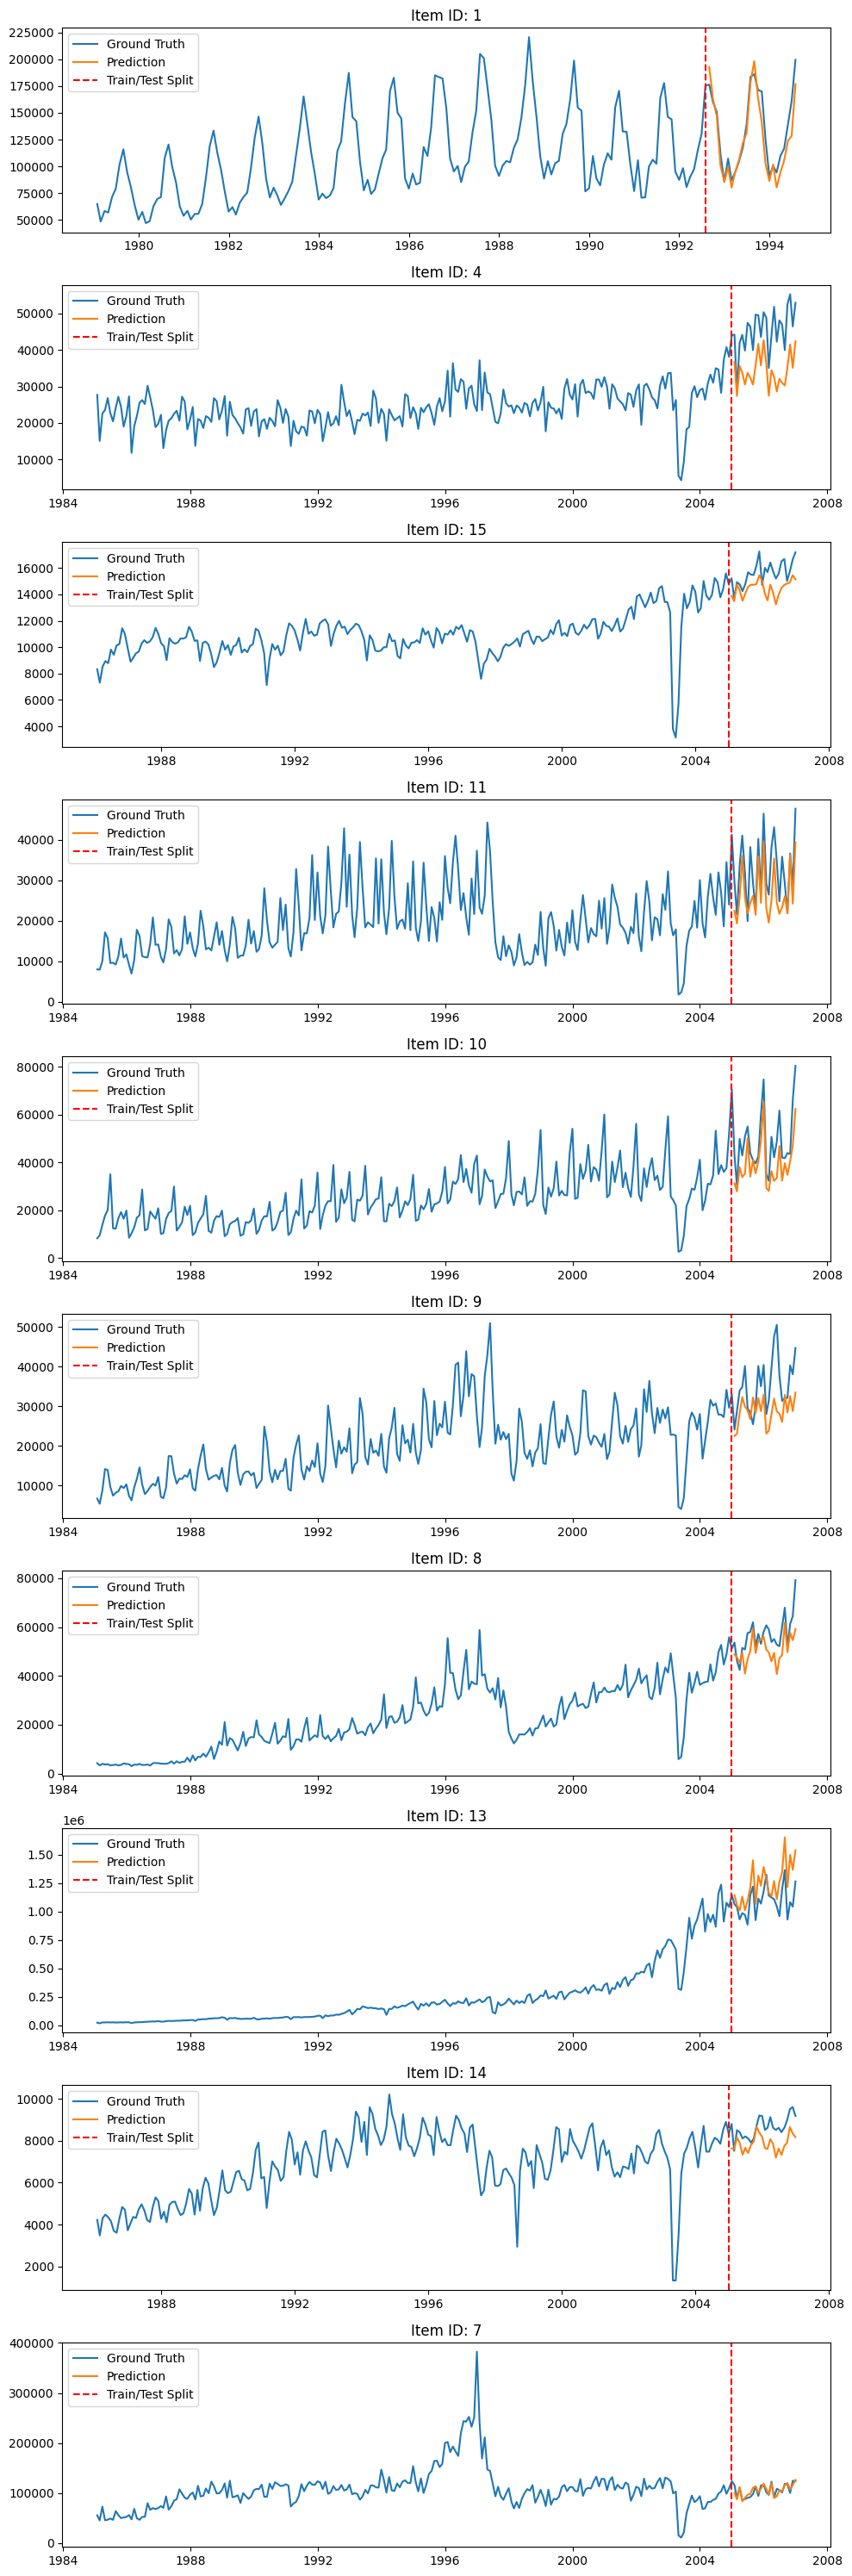

In [39]:
plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=all_noisy_preds[2],
    item_ids=item_ids_to_plot,
    show_quantiles=False,
)

In [14]:
from autogluon.timeseries.metrics.point import MASE
from autogluon.timeseries.utils.datetime import get_seasonality


MASEComputer = MASE()
MASEComputer.clear_past_metrics()

pred["mean"] = pred["target"]

# Set mean for all noisy predictions
# for noise_level, noisy_pred in all_noisy_preds.items():
#     all_noisy_preds[noise_level]["mean"] = all_noisy_preds[noise_level]["target"]

MASEComputer.save_past_metrics(
    data_past=train_tsdf,
    seasonal_period=get_seasonality(train_tsdf.freq),
)

clean_mase = MASEComputer.compute_metric(
    data_future=test_tsdf_ground_truth.slice_by_timestep(-prediction_length -1, -1),
    predictions=pred,
)

# Compute MASE for all noise levels
# noisy_mase_results = {}
# for noise_level, noisy_pred in all_noisy_preds.items():
#     noisy_mase_results[noise_level] = MASEComputer.compute_metric(
#         data_future=test_tsdf_ground_truth.slice_by_timestep(-prediction_length -1, -1),
#         predictions=noisy_pred,
#     )

# Return clean MASE and dictionary of noisy MASE results
clean_mase #, noisy_mase_results

ValueError: operands could not be broadcast together with shapes (384,1) (16,1) 

In [41]:
pred.head()

target          0.1          0.2          0.3  \
item_id timestamp                                                        
0       1992-08-31  6608.066895  6165.622070  6326.393555  6432.350586   
        1992-09-30  4162.634277  3875.321289  3976.080566  4048.607422   
        1992-10-31  3048.498291  2832.145020  2906.954834  2962.692627   
        1992-11-30  1992.670044  1791.869385  1861.110474  1911.584106   
        1992-12-31  2373.767578  2145.048584  2227.843994  2285.046875   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
0       1992-08-31  6524.198242  6608.066895  6692.628906  6785.706543   
        1992-09-30  4107.157715  4162.634277  4219.229980  4279.013672   
        1992-10-31  3007.079590  3048.498291  3094.091064  3142.134277   
        1992-11-30  1953.354248  1992.670044  2032.959961  2075.665283   
        1992-12-31  2331.643311  2373.767578  2414.006592  2457.378662   

                            0.8          0.9         mean  
item_id timestamp                                          
0       1992-08-31  6903.249512  7089.437012  6608.066895  
        1992-09-30  4353.288574  4465.961426  4162.634277  
        1992-10-31  3203.687744  3299.488037  3048.498291  
        1992-11-30  2127.512695  2201.609619  1992.670044  
        1992-12-31  2506.083496  2574.505127  2373.767578

# Feedback

Let us know what you think!

Write us at Discord: https://discord.gg/qK7AaXPN or just simply create an issue on [GitHub](https://github.com/liam-sbhoo/tabpfn-time-series/tree/main).

Thank you for trying out our method! 🎉
